# Full Global View Data Creation Notebook

The aim of this notebook is to cover the code used to generate the dataset for the 'Global View'.

### 1. Installing and Importing the necessary libraries

In [ ]:
# INSTALLING THE NECESSARY LIBRARIES
!pip install lightkurve
!pip install tslearn 

In [ ]:
# IMPORTING NECESSARY LIBRARIES
import lightkurve as lk
import pandas as pd
import numpy as np
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesResampler
from scipy import signal
import matplotlib.pyplot as plt

### 2. Processing the data with the KIC's

In [ ]:
# IMPORT AND PROCESSING THE KEPLER ID DATA
finalData = pd.read_csv('finalData.csv')
finalData = finalData[finalData['koi_disposition'].str.contains('CANDIDATE')==False] # removing 'candidate' rows
finalData = finalData.drop_duplicates(subset=['kepid']) # removing duplicates where kepid is repeated ==> CONTROVERSIAL!!! to deal with multiple planets (0, 1, 1+) classification, need raw data
finalData = finalData.replace(['CONFIRMED', 'FALSE POSITIVE'], [1, 0]) # converting 'confirmed' / 'false positive' into 1 / 0
finalData = finalData.reset_index(drop=True)
finalData

,kepid,koi_disposition,koi_period,koi_time0bk,koi_time0,koi_duration
0,10797460,1,9.488036,170.538750,2455003.539,2.95750
1,10848459,0,1.736952,170.307565,2455003.308,2.40641
2,10854555,1,2.525592,171.595550,2455004.596,1.65450
3,10872983,1,11.094321,171.201160,2455004.201,4.59450
4,6721123,0,7.361790,132.250530,2454965.251,5.02200
...,...,...,...,...,...,...
6605,10205598,0,373.893980,261.496800,2455094.497,27.66000
6606,10031643,0,8.589871,132.016100,2454965.016,4.80600
6607,10090151,0,0.527699,131.705093,2454964.705,3.22210
6608,10147276,0,0.681402,132.181750,2454965.182,0.86500


### 3. Main Data Creation Loop

In [ ]:
initial_X = []
initial_Y = []
i = 0 # dummy variable to verify the loop is working

for kepid in finalData['kepid'].iloc[0:500]:

  try: 
    # DOWNLOADING THE DATA
    KIC = 'KIC ' + str(kepid)
    lcs = lk.search_lightcurve(KIC, author='kepler', cadence='long').download_all()

    # FINDING THE PERIOD, T0 AND DURATION FOR PROCESSING
    row_number = finalData[finalData['kepid'] == kepid].index[0]
    period, t0, duration_hours =  finalData['koi_period'][row_number],  finalData['koi_time0bk'][row_number],  finalData['koi_duration'][row_number]
    
    # PROCESSING THE LIGHTKURVE DATA
    lc_raw = lcs.stitch()
    lc_clean = lc_raw.remove_outliers(sigma=20, sigma_upper=4)
    temp_fold = lc_clean.fold(period, epoch_time=t0)
    fractional_duration = (duration_hours / 24.0) / period
    phase_mask = np.abs(temp_fold.phase.value) < (fractional_duration * 1.5)
    transit_mask = np.in1d(lc_clean.time.value, temp_fold.time_original.value[phase_mask])
    lc_flat, trend_lc = lc_clean.flatten(return_trend=True, mask=transit_mask)
    lc_fold = lc_flat.fold(period, epoch_time=t0)
    
    # CREATING THE GLOBAL VIEW
    lc_global = lc_fold.bin(time_bin_size=0.005).normalize() - 1
    lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1


    # CONVERTING TO PANDAS DF
    lc_global = lc_global.to_pandas()

    # CREATE LISTS OF X (TIMESERIES DATA) AND Y (LABEL)
    initial_X.append(lc_global['flux'].tolist())
    initial_Y.append(finalData['koi_disposition'][row_number])

    print('Successful: ', i)
    i += 1


  except: 
    print('Not successful: ', i)
    i += 1
    pass

### 4. Processing the data into equal length time-series

In [ ]:
initial_X = [list(filter(lambda x: x == x, inner_list)) for inner_list in initial_X]
initial_X_2 = [x for x in initial_X if x != []]
empty_idx = [i for i,x in enumerate(initial_X) if not x]

for i in sorted(empty_idx, reverse=True):
  del initial_Y[i]


y = np.array(initial_Y)


time_series_X = to_time_series_dataset(initial_X_2)

resampled_time_series_X = TimeSeriesResampler(sz=time_series_X.shape[1]).fit_transform(time_series_X)

new = np.squeeze(resampled_time_series_X)

In [ ]:
numbers_list = [str(x) for x in range(new.shape[1])]

df = pd.DataFrame(new,columns=numbers_list)

df['target'] = y

In [ ]:
time_series_df = df.drop(columns=['target'])


new = pd.DataFrame()
for index, row in time_series_df.iterrows():
    current_row = row
    new_row = signal.resample(current_row, 1000)
    new_row_df = pd.DataFrame(new_row).transpose()
    new = pd.concat([new, new_row_df], ignore_index = True)

new['target'] = df['target']

df = new
df

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,target
0,0.788670,1.017671,0.876070,0.729574,1.078053,1.082654,1.208449,1.006913,1.002100,0.799759,...,1.044313,1.085145,1.068033,0.806972,1.045781,0.844242,1.047508,1.165386,0.936228,1
1,1.025474,1.021772,1.019600,1.014203,1.005880,0.994377,0.992688,1.009277,1.027724,1.036782,...,1.025476,1.029910,1.035835,1.035997,1.023994,1.010808,1.005035,1.012998,1.019985,0
2,1.151818,1.190304,1.324841,1.206936,1.098883,1.008371,0.955959,0.963000,0.982727,0.962660,...,1.182706,1.218410,1.040896,0.940937,0.965528,0.941000,0.889384,0.934605,1.210276,1
3,0.964213,1.017494,0.930191,1.000322,0.984453,1.008215,0.837074,1.041529,1.115980,1.225801,...,0.878675,0.962994,0.929531,0.935217,0.982872,1.054924,1.160217,0.992524,1.138617,1
4,0.887506,1.031877,0.953162,0.981358,0.768660,0.661819,0.734753,0.926450,0.827602,0.806662,...,1.135816,1.127726,1.101786,0.993737,1.130030,1.106410,1.220925,0.968154,1.017673,0


### 5. Visual Verification

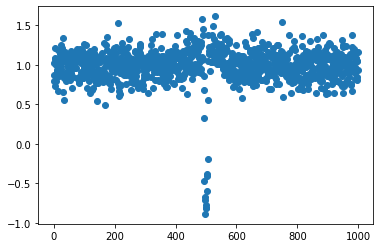

In [ ]:
 plt.scatter(np.arange(0,1000), df.iloc[0, 0:1000])